# Downloading S&P 500 History using Yahoo Finance tool

In [47]:
#Library from Yahoo Finance that gives us access to S&P500 market data for our model
import yfinance as yf

#Storing our data into a variable as a Pandas data frame
sp500 = yf.Ticker("^GSPC")

#Storing maximum history recorded of the index
sp500 = sp500.history(period="max")

<Axes: xlabel='Date'>

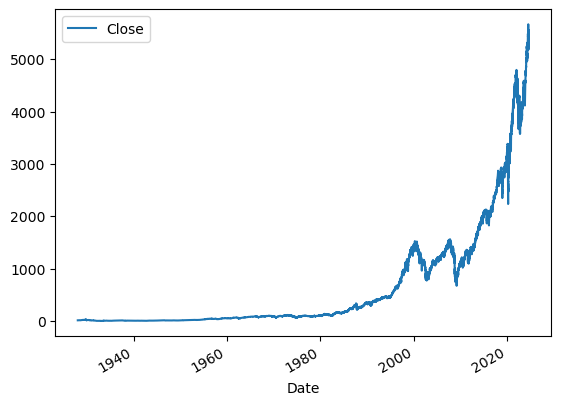

In [48]:
#Display our initial data trendline
sp500.plot.line(y="Close", use_index = True)

# Cleaning and Visualizing our stock market data

In [49]:
#Delete the Dividends and Stock splits columns as they are not needed
del sp500["Dividends"]
del sp500["Stock Splits"]

# Setting up the Target for our Machine Learning model

In [50]:
#Create new variable tomorrow, which we will use for displaying our prediction. Initiliaze to the closing price of the day before
sp500["Tomorrow"] = sp500["Close"].shift(-1)

#This target is what we are trying to predict in our model, using an int of 0 or 1 the model will use a one up/one down system
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

#Delete data before 1990, Market infrastructure has changed and therefore prior data will only offset our model
sp500 = sp500.loc["1990-01-01":].copy()


# Training an initial Machine Learning model

<Axes: xlabel='Date'>

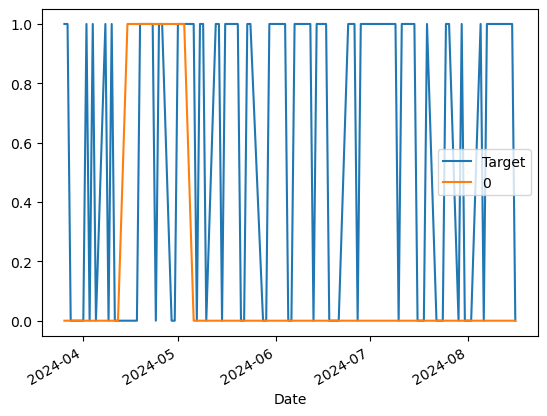

In [51]:
#The Random Forest classifier train through individual decision training trees and then averaging the results
#This process allows us to prevent overfitting in large data models
#Our result derives non-linear relationships which cater to the stock market in which most relationships are non-linear
from sklearn.ensemble import RandomForestClassifier

#Machine Learning model
#Random State set to 1 to have consistent prediction in which we can build off of
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)

#Training data set
#Using time series dataset, Cross Validation is not viable here do the nature of time
train = sp500.iloc[:-100]

#Train our data with all rows except last 100 days, test on the most recent 100
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]

model.fit(train[predictors], train["Target"])

#Import precision score, gives percentage of time that when we predict growth/loss we are true
from sklearn.metrics import precision_score

#Generate our prediction
preds = model.predict(test[predictors])

#Our model gives us our predictions in a numPy array, for data analysis we import Pandas to create a pandas series
import pandas as pd

#numPy array into a Series
preds = pd.Series(preds, index = test.index)

#calculate precision score, our raw model has a 53.8% accuracy for predicting the S&P 500
precision_score(test["Target"], preds)

combined = pd.concat([test["Target"], preds], axis = 1)

combined.plot()

# Building a Backtesting system

In [52]:

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [53]:
#Back test function training our model for about 1 year(step=250)
def backtest(data, model, predictors, start = 2500, step = 250):
    #list all predictions has a single number for our data frame of a single year
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)

In [54]:
#Running our backtesting model against 11 years of data and printing our accuracy
predictions = backtest(sp500, model, predictors)

#We have an accuracy of roughly 53% when we said the SPY would go up and if it acually did X amount of times
print("Accuracy of Model: ", precision_score(predictions["Target"], predictions["Predictions"]))

#Showing when the SPY went up(1) over when it went down(0)
#Will be used for comparison after adding additional predictors
predictions["Target"].value_counts() / predictions.shape[0]

Accuracy of Model:  0.5292083013066872


Target
1    0.535594
0    0.464406
Name: count, dtype: float64

# Adding additional predictors to our Model

In [55]:
#Looking at rolling averages to check, was stock higher 2 days ago, 3 months ago, etc
horizons = [2, 5, 60, 250, 1000]
new_predictors = []

for horizon in horizons:
    rolling_avg = sp500.rolling(horizon).mean() 
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_avg["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors += [ratio_column, trend_column]


In [56]:
#Pandas returns NaN to any data it cannot compute, using dropna we remove this problem
#ex: at the beginning of our dataset we cant compute two days in the past so panda returns NaN making those columns unusable
sp500 = sp500.dropna()

Improving our Model

In [67]:
model = RandomForestClassifier(n_estimators = 200, min_samples_split=50, random_state=1)

#Modifying our previos predict function, main change is predict to predictproba, this doesnt give us a 0 or 1 like before but rather the probability that it will be rising/dropping
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    #By default probability will be 0 or 1 by a decider of .5, but my modifying to .65 we increase the confidence to .65 so we less but more accurate "trading days"
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index = test.index, name = "Predictions")
    combined = pd.concat([test["Target"], preds], axis = 1)
    return combined

In [68]:
predictions = backtest(sp500, model, new_predictors)

In [69]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5751789976133651